### LOAD NECESSARY LIBRARIES


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt
import re
warnings.filterwarnings('ignore')
sns.set_style('whitegrid', {'axes.grid': False})

#### LOAD DATASETS

In [2]:
def load_df():
    """
    Load both datasets 
    """
    txn_data = pd.read_excel('./dataset/QVI_transaction_data.xlsx')
    cust_data = pd.read_csv('./dataset/QVI_purchase_behaviour.csv')
    return txn_data, cust_data
txn_data,cust_data = load_df()

#### EXAMINE DATASETS

##### EXAMINE TRANSACTION DATA

In [3]:
txn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


Date column in the transaction data shows as integer, meaning data is stored in excel integer format.

 In data cleaning process, it will be formatted to proper dates

In [4]:
txn_data.shape

(264836, 8)

##### DATA CLEANING

In [5]:
def clean_txn_data(txn_data):
    """
    data cleaning ensures data sets are free from :
    1. missing data
    2. duplicates
    3. date formatting
    """
    txn_data= txn_data.dropna()
    txn_data = txn_data.drop_duplicates()
    txn_data['DATE'] = pd.to_datetime(txn_data['DATE'],origin='1900-01-01', unit='D')
    return txn_data

txn_data = clean_txn_data(txn_data)
print("total missing data: \n",txn_data.isnull().sum())
print("total duplicated data: ",txn_data.duplicated().sum())

total missing data: 
 DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64
total duplicated data:  0


#### DISTRIBUTION OF NUMERICAL DATA

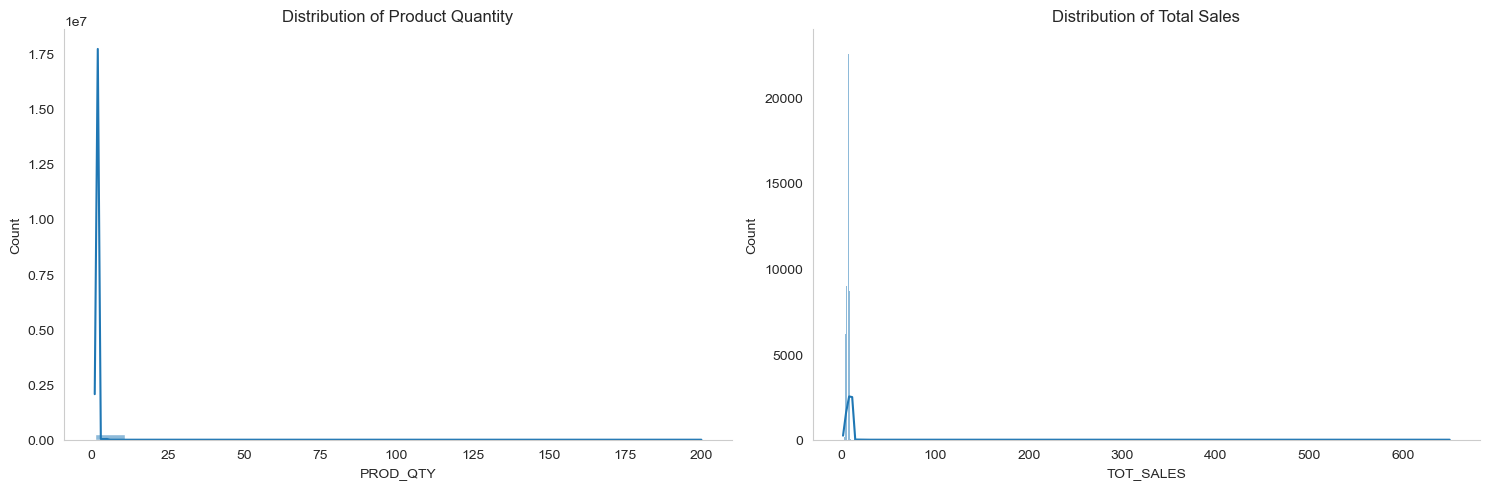

In [6]:

def plot_dist(txn_data):
    """
    Plot the numerical data of Prod QTY and Total sales
    """
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))

    axes[0] = sns.histplot(txn_data['PROD_QTY'],kde=True,ax=axes[0])
    axes[0].set_title("Distribution of Product Quantity")
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)



    axes[1]  = sns.histplot(txn_data['TOT_SALES'],kde=True,ax=axes[1])
    axes[1].set_title("Distribution of Total Sales")
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
plot_dist(txn_data)

#### OUTLIER DETECTION


In [7]:
txn_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264835,264835.000000,2.648350e+05,2.648350e+05,264835.000000,264835.000000,264835.000000
mean,2019-01-01 00:52:42.252722944,135.080216,1.355496e+05,1.351584e+05,56.583201,1.907308,7.304205
min,2018-07-03 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-10-02 00:00:00,70.000000,7.002100e+04,6.760100e+04,28.000000,2.000000,5.400000
50%,2019-01-01 00:00:00,130.000000,1.303580e+05,1.351380e+05,56.000000,2.000000,7.400000
75%,2019-04-02 00:00:00,203.000000,2.030945e+05,2.027015e+05,85.000000,2.000000,9.200000
max,2019-07-02 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.784306,8.058011e+04,7.813316e+04,32.826692,0.643655,3.083231


Max prod qty is 200, seems a bit too much.


In [8]:
txn_data[txn_data['PROD_QTY'] == 200].head(1)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-21,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0


User with loyallty card number 22600, ordered 200 chips at once, could he be a reseller?

next, I will check if there are more purchases like this from him.


In [9]:
txn_data[txn_data['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-21,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-22,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


He does this twice. 

Once in 2018 and again in 2019

He might be a reseller.

For the sake of analysis,we will remove this user.

In [10]:
txn_data = txn_data.drop(txn_data[txn_data['LYLTY_CARD_NBR'] == 226000].index)

In [11]:
txn_data.shape

(264833, 8)

In [12]:
txn_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,264833,264833.000000,2.648330e+05,2.648330e+05,264833.000000,264833.000000,264833.000000
mean,2019-01-01 00:52:39.666657792,135.079529,1.355489e+05,1.351577e+05,56.583598,1.905812,7.299351
min,2018-07-03 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.500000
25%,2018-10-02 00:00:00,70.000000,7.002100e+04,6.760000e+04,28.000000,2.000000,5.400000
50%,2019-01-01 00:00:00,130.000000,1.303570e+05,1.351370e+05,56.000000,2.000000,7.400000
75%,2019-04-02 00:00:00,203.000000,2.030940e+05,2.027000e+05,85.000000,2.000000,9.200000
max,2019-07-02 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.784189,8.058003e+04,7.813305e+04,32.826498,0.343437,2.527244


The maximum quantity of chips purchased is 5, this seems fair.

####  EXAMINE CUSTOMER DATA

In [13]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [14]:
def clean_cst_data(cust_data):
    """ 
    This function checks and cleans the following
    1. missing data
    2. duplicated data
    """
    cust_data = cust_data.dropna()
    cust_data =  cust_data.drop_duplicates()
    return cust_data
cust_data =clean_cst_data(cust_data)

The dataset is categorical so no outliers. 

Dataset can be merged now

In [15]:
csm_txn_df = pd.merge(left=txn_data,right=cust_data, how='inner')

In [16]:
csm_txn_df.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-19,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-16,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-22,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget


### DATA CLEANING  AND FEATURE ENGINEERING

##### OBJECTIVE
Our objective is to understand the customers purchasing behavior when it comes to chips, to that end only chip related products are important to have in the dataset, the rest will be removed. Other products will be classsified as noise and we do not want that in our analysis.

#### FEATURE ENGINEERING

For gain a deeper understanding of customer chip purchasing behavior, important features will be extracted and they are as follows:

- DAY
- MONTH
- CHIP BRAND
- PACK SIZE

These features will help stakeholders to understand day to day purchases, sales each quarter, what brands are purchased frequently by customers, and if pack size have an impact in purchase behavior.

In [17]:
def clean_extract_features(csm_txn_df):
    """
    This function will
    1. search and extract chip-related products within the dataset
    2. create new features as (day, month, chip brand, and pack size) for further analysis
    """
    # 1. Search and extract by filtering out any product that isn't a chip
    csm_txn_df = csm_txn_df[csm_txn_df['PROD_NAME'].str.contains('chip', case=False, na=False)]

    # Clean product names (lowercase, remove unnecessary spaces and special characters)
    csm_txn_df['PROD_NAME'] = csm_txn_df['PROD_NAME'].str.lower()
    # Remove non-alphanumeric characters (except spaces)
    csm_txn_df['PROD_NAME'] = csm_txn_df['PROD_NAME'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
    # Remove extra spaces
    csm_txn_df['PROD_NAME'] = csm_txn_df['PROD_NAME'].str.replace(r'\s+', ' ', regex=True).str.strip()

    # 2. Feature engineering

    # Extract chip brand (remove 'chip' and digits with optional letters)
    csm_txn_df['CHIP_BRAND'] = csm_txn_df['PROD_NAME'].str.replace(r'\bchip\b|\d+[a-z]?', '', regex=True).str.strip()

    # Extract month, day, and year from the date
    csm_txn_df['MONTH'] = csm_txn_df['DATE'].dt.month
    csm_txn_df['DAY'] = csm_txn_df['DATE'].dt.day
    csm_txn_df['YEAR'] = csm_txn_df['DATE'].dt.year

    # Extract pack size (just the number, without 'g')
    csm_txn_df['PACK_SIZE'] = csm_txn_df['PROD_NAME'].str.extract(r'(\d+)(?=\s?g)', expand=False)

    return csm_txn_df
csm_txn_df = clean_extract_features(csm_txn_df)

In [18]:
csm_txn_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,CHIP_BRAND,MONTH,DAY,YEAR,PACK_SIZE
0,2018-10-19,1,1000,1,5,natural chip compny seasalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,natural compny seasalt,10,19,2018,175
2,2019-05-22,1,1343,383,61,smiths crinkle cut chips chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,smiths crinkle cut chips chicken,5,22,2019,170
3,2018-08-19,2,2373,974,69,smiths chip thinly screamonion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,smiths thinly screamonion,8,19,2018,175
6,2019-05-18,4,4149,3333,16,smiths crinkle chips salt vinegar 330g,1,5.7,MIDAGE SINGLES/COUPLES,Budget,smiths crinkle chips salt vinegar,5,18,2019,330
8,2018-08-22,5,5026,4525,42,doritos corn chip mexican jalapeno 150g,1,3.9,MIDAGE SINGLES/COUPLES,Budget,doritos corn mexican jalapeno,8,22,2018,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264812,2018-11-06,271,271193,269365,33,cobs popd swtchlli srcream chips 110g,2,7.6,YOUNG SINGLES/COUPLES,Premium,cobs popd swtchlli srcream chips,11,6,2018,110
264813,2019-05-31,271,271193,269366,75,cobs popd sea salt chips 110g,2,7.6,YOUNG SINGLES/COUPLES,Premium,cobs popd sea salt chips,5,31,2019,110
264823,2019-03-27,272,272194,269908,75,cobs popd sea salt chips 110g,2,7.6,YOUNG SINGLES/COUPLES,Premium,cobs popd sea salt chips,3,27,2019,110
264827,2018-11-14,272,272319,270087,44,thins chips light tangy 175g,2,6.6,YOUNG SINGLES/COUPLES,Premium,thins chips light tangy,11,14,2018,175


In [19]:
csm_txn_df['CHIP_BRAND'].unique()

array(['natural  compny seasalt', 'smiths crinkle cut chips chicken',
       'smiths  thinly screamonion', 'smiths crinkle chips salt vinegar',
       'doritos corn  mexican jalapeno', 'thins chips light tangy',
       'doritos corn  southern chicken', 'smiths  thinly cut original',
       'thins chips originl saltd', 'natural chipco hony soy chckn',
       'thins chips seasonedchicken', 'doritos corn chips original',
       'cobs popd swtchlli srcream chips', 'natural  co tmato hrbspce',
       'smiths crinkle cut chips original', 'cobs popd sea salt chips',
       'smiths crinkle cut chips chsonion', 'french fries potato chips',
       'doritos corn chips cheese supreme', 'ww original corn chips',
       'thins potato chips hot spicy', 'cobs popd sour crm chives chips',
       'smiths crnkle  orgnl big bag', 'doritos corn chips nacho cheese',
       'ww dstyle  sea salt', 'ww original stacked chips',
       'smiths  thinly cutsaltvinegr', 'thins chips salt vinegar',
       'smiths cr

In [20]:
brand_replacements = {
    r'\bsaltd\b': 'salted',
    r'\bcrm\b': 'cream',
    r'\btmato\b': 'tomato',
    r'\bww\b': 'woolworths',
    r'\bdstyle\b': 'style',
    r'\bchsonion\b': 'onion',
    r'\bscreamonion\b': 'cream onion',
    r'\bcutsaltvinegr\b': 'salt vinegar',
    r'\bcompny\b' : 'company',
    r'\bseasonedchicken\b' : 'seasoned chicken',
    r'\bswtchlli\b' : 'sweet chilli',
    r'\bsrcream\b' : 'sour cream',
    r'\bchckn\b' : 'chicken',
    r'\bco\b' : 'company',
    r'\bhny\b' : 'honey',
    r'\borgnl\b' : 'original',
}

def cleaned_names(text):
    for old_name, new_name in brand_replacements.items():
        text=re.sub(old_name,new_name,text)
    return text
csm_txn_df['CHIP_BRAND'] = csm_txn_df['CHIP_BRAND'].apply(cleaned_names)
#revisit the unique names to confirm
csm_txn_df['CHIP_BRAND'].unique()

array(['natural  company seasalt', 'smiths crinkle cut chips chicken',
       'smiths  thinly cream onion', 'smiths crinkle chips salt vinegar',
       'doritos corn  mexican jalapeno', 'thins chips light tangy',
       'doritos corn  southern chicken', 'smiths  thinly cut original',
       'thins chips originl salted', 'natural chipco hony soy chicken',
       'thins chips seasoned chicken', 'doritos corn chips original',
       'cobs popd sweet chilli sour cream chips',
       'natural  company tomato hrbspce',
       'smiths crinkle cut chips original', 'cobs popd sea salt chips',
       'smiths crinkle cut chips onion', 'french fries potato chips',
       'doritos corn chips cheese supreme',
       'woolworths original corn chips', 'thins potato chips hot spicy',
       'cobs popd sour cream chives chips',
       'smiths crnkle  original big bag',
       'doritos corn chips nacho cheese', 'woolworths style  sea salt',
       'woolworths original stacked chips', 'smiths  thinly salt

### EDA  AND VISUALIZATION

1. What are the number of transactions that occur every day?
